# Execução do notebook de pre-processamento

Essa execução irá carregar aqui todas as importações e variaveis de ambiente criadas no notebook **preprocessing.ipynb**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

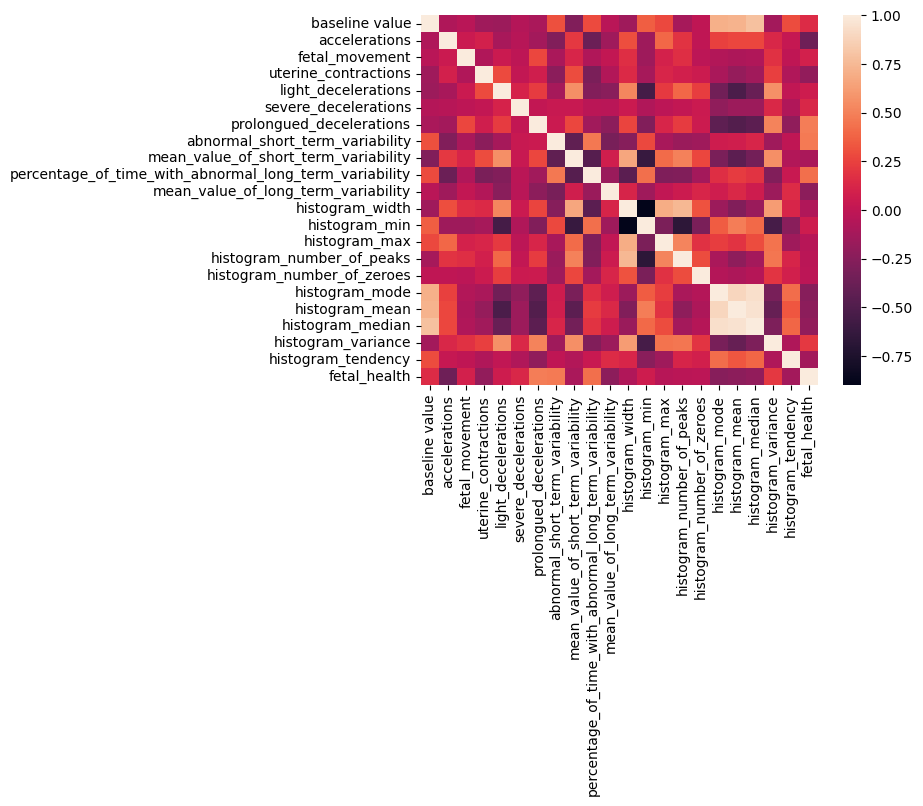

In [1]:
%run preprocessing.ipynb

# Random Forest Classifier

## Quantidade do alvo fetal_health

In [2]:
fetal_health.fetal_health.value_counts()

1.0    1646
2.0     292
3.0     175
Name: fetal_health, dtype: int64

## Colunas com correlação maior que 0.08

In [3]:
fetal_health_corr = fetal_health.corr().abs().fetal_health
cols_drops = (fetal_health_corr[fetal_health_corr < 0.08]).index
cols_drops

Index(['light_decelerations', 'histogram_width', 'histogram_min',
       'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes'],
      dtype='object')

In [4]:
X_train.drop(columns=cols_drops, inplace=True)
X_test.drop(columns=cols_drops, inplace=True)

## Pipeline

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

steps = [
    ("ss", StandardScaler()),
    ("rf", RandomForestClassifier()),
]

pipe = Pipeline(steps)

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score, accuracy_score

spliter = KFold(n_splits=10, shuffle=True, random_state=42)
score = make_scorer(recall_score, labels=[2, 3], average="micro")

## Treinamento com Grid Search CV

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "rf__n_estimators": range(100, 1_000, 100),
    "rf__criterion": ["gini", "entropy", "log_loss"],
    "rf__max_depth": range(3, 8),
    "rf__class_weight": ["balanced", "balanced_subsample"],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=spliter,
    scoring=score,
    n_jobs=-1,
)

grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__class_weight': ['balanced', 'balanced_subsample'],
                         'rf__criterion': ['gini', 'entropy', 'log_loss'],
                         'rf__max_depth': range(3, 8),
                         'rf__n_estimators': range(100, 1000, 100)},
             scoring=make_scorer(recall_score, labels=[2, 3], average=micro))

## Melhores parâmetros

In [8]:
grid.best_estimator_, grid.best_params_

(Pipeline(steps=[('ss', StandardScaler()),
                 ('rf',
                  RandomForestClassifier(class_weight='balanced', max_depth=6,
                                         n_estimators=600))]),
 {'rf__class_weight': 'balanced',
  'rf__criterion': 'gini',
  'rf__max_depth': 6,
  'rf__n_estimators': 600})

## Predição da base de Treino

              precision    recall  f1-score   support

         1.0       0.99      0.92      0.96      1316
         2.0       0.69      0.96      0.80       234
         3.0       0.99      0.97      0.98       140

    accuracy                           0.93      1690
   macro avg       0.89      0.95      0.91      1690
weighted avg       0.95      0.93      0.94      1690



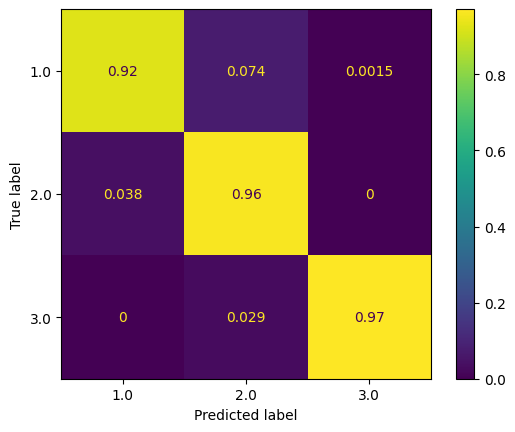

In [9]:
from sklearn.preprocessing import normalize


print_report(grid, X_train, y_train, normalize="true")

## Predição da base de teste

              precision    recall  f1-score   support

         1.0       0.97      0.94      0.96       330
         2.0       0.69      0.84      0.76        58
         3.0       0.97      0.91      0.94        35

    accuracy                           0.92       423
   macro avg       0.88      0.90      0.89       423
weighted avg       0.93      0.92      0.93       423



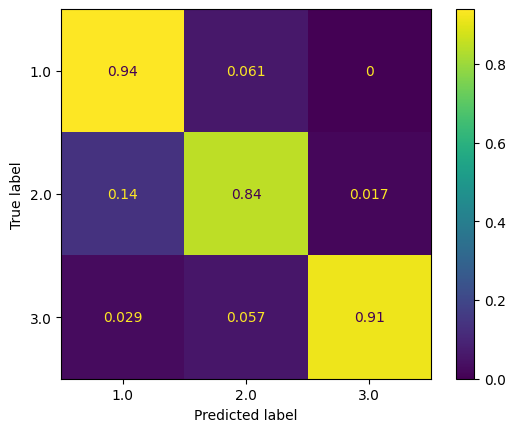

In [10]:
print_report(grid, X_test, y_test, normalize="true")